## PART 1 — Imports and load dataset 

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap
import joblib

# Load file (must be in same folder)
df = pd.read_csv("diabetic_data.csv")
print("Shape:", df.shape)
df.head()


Shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### PART 2 — Replace '?' with NaN and quick required columns check

In [ ]:

df.replace('?', np.nan, inplace=True)

required = ['race','gender','age','admission_type_id','discharge_disposition_id',
            'admission_source_id','time_in_hospital','num_lab_procedures','num_procedures',
            'num_medications','number_outpatient','number_emergency','number_inpatient',
            'number_diagnoses','diag_1','diag_2','diag_3','max_glu_serum','A1Cresult',
            'change','diabetesMed','readmitted']

missing = [c for c in required if c not in df.columns]
print("Missing required columns:", missing)
# quick target distribution
print("readmitted value counts (raw):")
print(df['readmitted'].value_counts(dropna=False))


Missing required columns: []
readmitted value counts (raw):
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


### PART 3 — Target conversion and drop rows missing critical fields

In [ ]:
#  create binary target and drop rows missing key columns
df = df.copy()
# Convert target
df['readmitted_bin'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Drop rows missing extremely important columns to avoid many edge cases
df.dropna(subset=['race','gender','age','diag_1'], inplace=True)

print("After dropping, shape:", df.shape)
print("Binary target counts:\n", df['readmitted_bin'].value_counts())


After dropping, shape: (99474, 51)
Binary target counts:
 readmitted_bin
0    88310
1    11164
Name: count, dtype: int64


## PART 4 — Small, essential feature selection 

In [ ]:
# keep a practical subset of features (as required by task)
cols_keep = ['race','gender','age','admission_type_id','discharge_disposition_id',
             'admission_source_id','time_in_hospital','num_lab_procedures','num_procedures',
             'num_medications','number_outpatient','number_emergency','number_inpatient',
             'number_diagnoses','diag_1','diag_2','diag_3','max_glu_serum','A1Cresult',
             'change','diabetesMed','readmitted_bin']

cols_keep = [c for c in cols_keep if c in df.columns]
df = df[cols_keep].copy()
print("Kept columns:", df.columns.tolist())
df.head()


Kept columns: ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'readmitted_bin']


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,number_inpatient,number_diagnoses,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,change,diabetesMed,readmitted_bin
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,0,1,250.83,NaN,NaN,NaN,NaN,No,No,0
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,0,9,276,250.01,255,NaN,NaN,Ch,Yes,0
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,1,6,648,250,V27,NaN,NaN,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,0,7,8,250.43,403,NaN,NaN,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,0,5,197,157,250,NaN,NaN,Ch,Yes,0


#### PART 5 — Feature engineering: age_mid, polypharmacy, chronic flags, prior admission 

In [ ]:
#  feature engineering
def age_to_mid(age_str):
    try:
        s = age_str.strip().strip('[]()')
        lo,hi = s.split('-')
        return (int(lo)+int(hi))/2
    except:
        return np.nan

df['age_mid'] = df['age'].apply(age_to_mid)
# polypharmacy (tunable): choose >8 medications as threshold
df['polypharmacy'] = (df['num_medications'] > 8).astype(int)

# chronic flag from diag_1 simple heuristic
def chronic_flag(code):
    if pd.isna(code): return 0
    try:
        c = str(code).split('.')[0]
        n = int(c)
        if 390 <= n <= 459: return 1
        if 240 <= n <= 279: return 1
        if 460 <= n <= 519: return 1
        if n == 250: return 1
        return 0
    except:
        return 0

df['chronic_diag1'] = df['diag_1'].apply(chronic_flag)

# prior admissions flag
df['prior_admission_count'] = df['number_inpatient'] + df['number_emergency'] + df['number_outpatient']
df['any_prior_admission'] = (df['prior_admission_count'] > 0).astype(int)

# drop original 'age' if you want numeric only later
print("New features added. Sample:")
df[['age','age_mid','polypharmacy','chronic_diag1','prior_admission_count']].head()


New features added. Sample:


,age,age_mid,polypharmacy,chronic_diag1,prior_admission_count
0,[0-10),5.0,0,1,0
1,[10-20),15.0,1,1,0
2,[20-30),25.0,1,0,3
3,[30-40),35.0,1,0,0
4,[40-50),45.0,0,0,0


### PART 6 — Prepare modeling dataframe & encode categorical colum

In [ ]:
# prepare df_model, label encoding for categorical columns
# Drop raw diag strings (we used diag_1 to create chronic flag). Keep diag_2/3 optional; drop them for speed to avoid huge cardinality
df_model = df.drop(columns=['age','diag_1','diag_2','diag_3'], errors='ignore')

# Identify categorical columns (object dtype)
cat_cols = df_model.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c != 'readmitted_bin']
cat_cols
# Label encode each categorical column simply
le_dict = {}
for c in cat_cols:
    df_model[c] = df_model[c].astype(str).fillna('NA')
    le = LabelEncoder()
    df_model[c] = le.fit_transform(df_model[c])
    le_dict[c] = le

# Fill numeric NaNs with median
df_model.fillna(df_model.median(numeric_only=True), inplace=True)

# Final features and target
features = [c for c in df_model.columns if c != 'readmitted_bin']
X = df_model[features].copy()
y = df_model['readmitted_bin'].copy()

print("Features count:", len(features))
X.head()


Features count: 22


,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,age_mid,polypharmacy,chronic_diag1,prior_admission_count,any_prior_admission
0,2,0,6,25,1,1,41,0,1,0,...,1,3,3,1,0,5.0,0,1,0,0
1,2,0,1,1,7,3,59,0,18,0,...,9,3,3,0,1,15.0,1,1,0,0
2,0,0,1,1,7,2,11,5,13,2,...,6,3,3,1,1,25.0,1,0,3,1
3,2,1,1,1,7,2,44,1,16,0,...,7,3,3,0,1,35.0,1,0,0,0
4,2,1,1,1,7,1,51,0,8,0,...,5,3,3,0,1,45.0,0,0,0,0


### PART 7 — Train/Test split and scaling numeric features 

In [ ]:
# split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numeric features for Logistic Regression (trees don't need)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (79579, 22) Test size: (19895, 22)


### PART 8 — Model training: Logistic Regression, Random Forest, XGBoost 

In [ ]:
#  train 3 models 
# Logistic Regression (baseline)
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:,1]

# Random Forest
rf = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

# XGBoost (optional but helpful)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:,1]

print("Models  trained")

Models trained.


In [ ]:
#  Cross-validation for F1 score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# Using cross-validation on Logistic Regression (balanced)
cv_f1_lr = cross_val_score(lr, X, y, cv=5, scoring=make_scorer(f1_score))
print("Logistic Regression CV F1 mean:", cv_f1_lr.mean())

# Random Forest
cv_f1_rf = cross_val_score(rf, X, y, cv=5, scoring=make_scorer(f1_score))
print("Random Forest CV F1 mean:", cv_f1_rf.mean())

# XGBoost
cv_f1_xgb = cross_val_score(xgb_clf, X, y, cv=5, scoring=make_scorer(f1_score))
print("XGBoost CV F1 mean:", cv_f1_xgb.mean())


Logistic Regression CV F1 mean: 0.25219782927314416
Random Forest CV F1 mean: 0.006730655790707865
XGBoost CV F1 mean: 0.048414634694406045


### Part 9 — evaluation function + reports

---- Logistic Regression ----
Accuracy: 0.6518723297310882
F1: 0.25686695278969957
Recall: 0.5360501567398119
Precision: 0.16890080428954424
ROC-AUC: 0.6421569519863539
Confusion matrix:
 [[11772  5890]
 [ 1036  1197]]
              precision    recall  f1-score   support

           0       0.92      0.67      0.77     17662
           1       0.17      0.54      0.26      2233

    accuracy                           0.65     19895
   macro avg       0.54      0.60      0.51     19895
weighted avg       0.83      0.65      0.71     19895

---- Random Forest ----
Accuracy: 0.8871575772807238
F1: 0.01491882404563405
Recall: 0.00761307657859382
Precision: 0.3695652173913043
ROC-AUC: 0.6349836023741428
Confusion matrix:
 [[17633    29]
 [ 2216    17]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17662
           1       0.37      0.01      0.01      2233

    accuracy                           0.89     19895
   macro avg       0.63

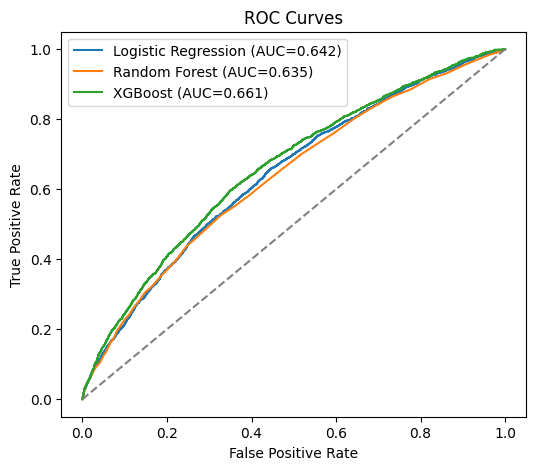

In [ ]:
#  evaluation function + reports
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate(y_true, y_pred, y_proba, name):
    print(f"---- {name} ----")
    print("Accuracy:", accuracy_score(y_true,y_pred))
    print("F1:", f1_score(y_true,y_pred))
    print("Recall:", recall_score(y_true,y_pred))
    print("Precision:", precision_score(y_true,y_pred))
    print("ROC-AUC:", roc_auc_score(y_true,y_proba))
    print("Confusion matrix:\n", confusion_matrix(y_true,y_pred))
    print(classification_report(y_true,y_pred))
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_true,y_proba):.3f})")

plt.figure(figsize=(6,5))
evaluate(y_test, y_pred_lr, y_proba_lr, "Logistic Regression")
evaluate(y_test, y_pred_rf, y_proba_rf, "Random Forest")
evaluate(y_test, y_pred_xgb, y_proba_xgb, "XGBoost")
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


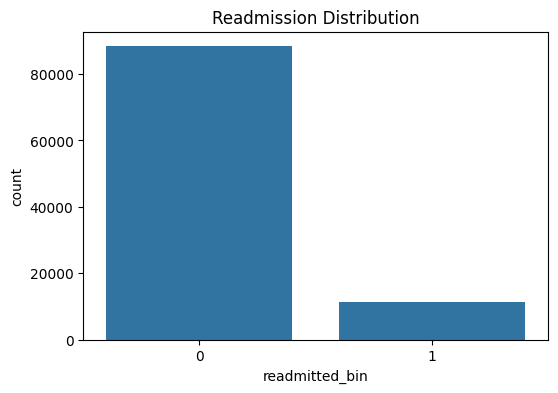

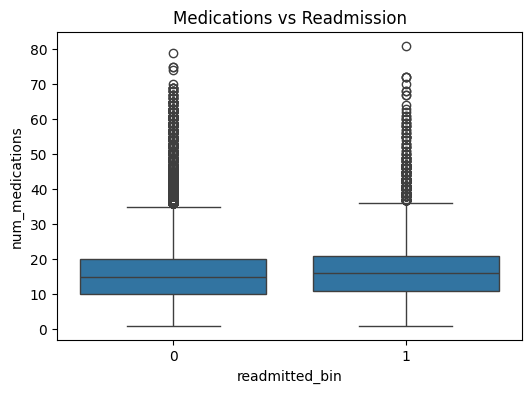

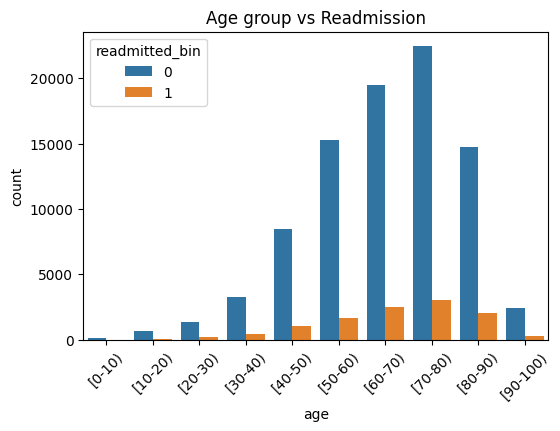

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='readmitted_bin', data=df)
plt.title('Readmission Distribution')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='readmitted_bin', y='num_medications', data=df)
plt.title('Medications vs Readmission')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='age', hue='readmitted_bin', data=df)
plt.title('Age group vs Readmission')
plt.xticks(rotation=45)
plt.show()


## Part 10 _ roc-curve

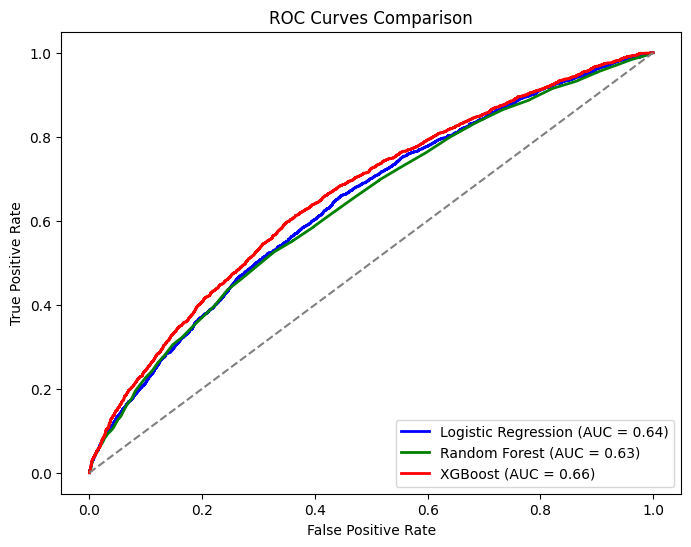

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate FPR, TPR for each model
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.show()


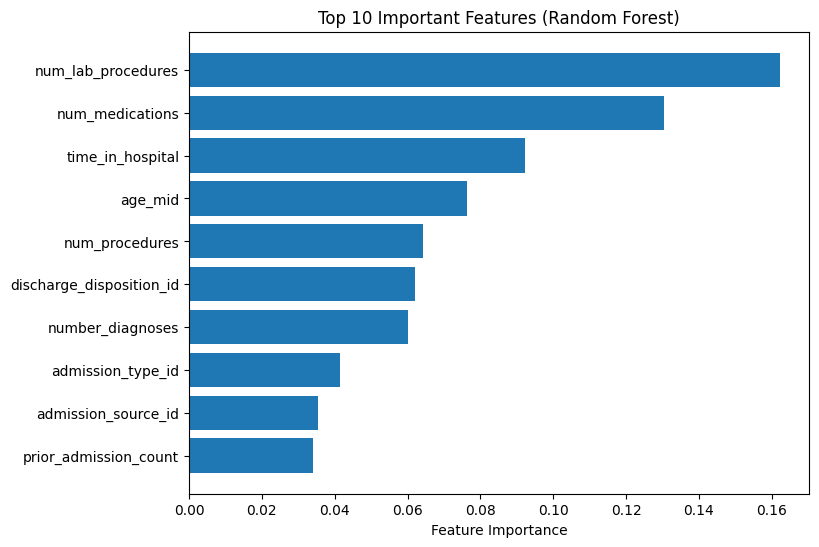

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importance for Random Forest
importances = rf.feature_importances_
features = X_train.columns

# Sort by importance
indices = importances.argsort()[::-1]
top_features = 10  # show top 10

plt.figure(figsize=(8, 6))
plt.barh(range(top_features), importances[indices][:top_features][::-1])
plt.yticks(range(top_features), features[indices][:top_features][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (Random Forest)")
plt.show()
